## Imports

In [1]:
import os
import pickle
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from nltk.translate.bleu_score import corpus_bleu
import torch.backends.cudnn as cudnn
from collections import Counter
import nltk
from nltk.translate.bleu_score import SmoothingFunction
from collections import Counter

2024-01-31 08:05:41.802241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 08:05:41.802357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 08:05:41.922523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install rouge

from rouge import Rouge


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Paths

In [4]:
dataset_path = '/kaggle/input/flickr-image-dataset/flickr30k_images'
images_folder = os.path.join(dataset_path, 'flickr30k_images')
texts = os.path.join(dataset_path, 'results.csv')

## Transform

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Vocabulary Class

In [6]:
class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")


    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold



    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(str(text))]

    def build_vocab(self, sentence_list):
        frequencies = Counter()

        #staring index 4
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(str(text))
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]


## Creat Dataset Class

In [7]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        # self.df = pd.read_csv(caption_file, delimiter = '|')
        self.df = caption_file
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image_name"]
        self.captions = self.df[" comment"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

## Collate Class

In [8]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

## Create Dataloader 

In [9]:
def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    """
    Returns torch dataloader for the flicker8k dataset

    Parameters
    -----------
    dataset: FlickrDataset
        custom torchdataset named FlickrDataset
    batch_size: int
        number of data to load in a particular batch
    shuffle: boolean,optional;
        should shuffle the datasests (default is False)
    num_workers: int,optional
        numbers of workers to run (default is 1)
    """

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader

## Show Image Function

In [10]:
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Attention Class

In [11]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)




    def forward(self, features, hidden_state):
        u_hs = self.U(features)     
        w_ah = self.W(hidden_state) 

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) 

        attention_scores = self.A(combined_states)        
        attention_scores = attention_scores.squeeze(2)     


        alpha = F.softmax(attention_scores,dim=1)         

        attention_weights = features * alpha.unsqueeze(2)  
        attention_weights = attention_weights.sum(dim=1)   

        return alpha,attention_weights



## Create Train Val Test

In [12]:
captions_file = pd.read_csv(texts, delimiter='|')
total_groups = len(captions_file) // 5

# Create a column to represent the group number for each row
captions_file['image_group'] = np.repeat(np.arange(total_groups), 5)[:len(captions_file)]

# Shuffle the groups randomly
shuffled_groups = np.random.permutation(captions_file['image_group'].unique())

# Split the groups into train, validation, and test sets
train_groups = shuffled_groups[:int(0.7 * len(shuffled_groups))]
val_groups = shuffled_groups[int(0.7 * len(shuffled_groups)):int(0.85 * len(shuffled_groups))]
test_groups = shuffled_groups[int(0.85 * len(shuffled_groups)):]

# Create train, validation, and test sets based on the selected groups
train_captions = captions_file[captions_file['image_group'].isin(train_groups)]
val_captions = captions_file[captions_file['image_group'].isin(val_groups)]
test_captions = captions_file[captions_file['image_group'].isin(test_groups)]

# Remove the temporary 'image_group' column
train_captions = train_captions.drop('image_group', axis=1)
val_captions = val_captions.drop('image_group', axis=1)
test_captions = test_captions.drop('image_group', axis=1)

# Optionally, reset index for each subset if needed
train_captions.reset_index(drop=True, inplace=True)
val_captions.reset_index(drop=True, inplace=True)
test_captions.reset_index(drop=True, inplace=True)

# Verify the lengths of each subset
print(f"Train set length: {len(train_captions)}")
print(f"Validation set length: {len(val_captions)}")
print(f"Test set length: {len(test_captions)}")

Train set length: 111240
Validation set length: 23835
Test set length: 23840


In [13]:
#testing the dataset class
trainset =  FlickrDataset(root_dir = images_folder, caption_file = train_captions, transform=transform)
valset =  FlickrDataset(root_dir = images_folder, caption_file = val_captions, transform=transform)
testset =  FlickrDataset(root_dir = images_folder, caption_file = test_captions, transform=transform)
# dataset = FlickrDataset(root_dir = images_folder, caption_file = captions_file, transform=transform)

#writing the dataloader
trainloader = get_data_loader(
    dataset=trainset, batch_size=128, num_workers=1, shuffle=True,
    # batch_first=False
)

valloader = get_data_loader(
    dataset=valset, batch_size=128, num_workers=1, shuffle=True,
    # batch_first=False
)

testloader = get_data_loader(
    dataset=testset, batch_size=128, num_workers=1, shuffle=True,
    # batch_first=False
)


## Model Classes

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


In [15]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()

        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)


        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)


        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)



    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)

        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:,s] = output
            alphas[:,s] = alpha


        return preds, alphas

    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)


        captions = []

        for i in range(max_len):
            alpha,context = self.attention(features, h)


            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas


    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


    def compute_bleu_score(self, features, captions, vocab_ref, vocab_gen, n_gram=2):
        # Generate captions using your existing function
        generated_captions, _ = self.generate_caption(features, max_len=20, vocab=vocab_gen)
        references = [[vocab_ref.itos[idx] for idx in caption[1:-1]] for caption in captions.tolist()]
        references = [[word for word in sublist if word != '<PAD>'] for sublist in references]

        # BLEU score
        smoothie = SmoothingFunction().method4
        bleu_score = corpus_bleu(references, [generated_captions], smoothing_function=smoothie, weights=(0.5, 0.5))

        # ROUGE-N score
        rouge = Rouge()
        rouge_n_score = rouge.get_scores(" ".join(generated_captions), " ".join(references[0]), avg=True)

        return bleu_score, rouge_n_score


In [16]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(trainset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Initiate Model


In [17]:
#Hyperparams
embed_size=300
vocab_size = len(trainset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

#init model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(trainset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=trainset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.4MB/s]


In [18]:
# model

## Training

In [19]:
from tqdm import tqdm

num_epochs = 10
train_losses = []
val_losses = []
bleu_scores = []
rouge_1s = []
rouge_2s = []
rouge_ls = []

best_bleu_score = 0
best_rouge_score = 0
patience = 7
counter = 0

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    # Use tqdm to create a progress bar for training
    for idx, (image, captions) in enumerate(tqdm(iter(trainloader), desc=f'Epoch {epoch}/{num_epochs}', unit='batch')):
        image, captions = image.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs, attentions = model(image, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    blue_s = 0
    rouge_1 = 0
    rouge_2 = 0
    rouge_l = 0
    # Use tqdm for validation as well
    for idx, (image, captions) in enumerate(tqdm(iter(valloader), desc=f'Validation', unit='batch')):
        image, captions = image.to(device), captions.to(device)
        outputs, attentions = model(image, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        running_val_loss += loss.item()

        # Compute BLEU score for each image
        features = model.encoder(image)  # Extract features for all input images
        for i in range(features.size(0)):
            single_feature = features[i].unsqueeze(0)  # Take features of a single image
            single_caption = captions[i].unsqueeze(0)  # Take captions of a single image
            bleu_score, rouge_score = model.decoder.compute_bleu_score(single_feature, single_caption, vocab_ref=valset.vocab, vocab_gen=trainset.vocab)
            blue_s = blue_s + bleu_score
            rouge1 = rouge_score['rouge-1']['f']
            rouge2 = rouge_score['rouge-2']['f']
            rougel = rouge_score['rouge-l']['f']
            rouge_1 = rouge_1 + rouge1
            rouge_2 = rouge_2 + rouge2
            rouge_l = rouge_l + rougel
    
    blue_s = blue_s / len(valset)
    rouge_1 = rouge_1 / len(valset)
    rouge_2 = rouge_2 / len(valset)
    rouge_l = rouge_l / len(valset)
    bleu_scores.append(blue_s)
    rouge_1s.append(rouge_1)
    rouge_2s.append(rouge_2)
    rouge_ls.append(rouge_l)
    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f} ',
          f'Validation Loss: {val_loss:.4f} ',
          f'Rouge 1: {rouge_1:.4f} ',
          f'Rouge 2: {rouge_2:.4f} ',
          f'Rouge L: {rouge_l:.4f} ',
          f'BLEU: {blue_s:.4f}')

    if rouge_1 > best_rouge_score:
        best_rouge_score = rouge_1
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    model.train()

Validation: 100%|██████████| 187/187 [06:49<00:00,  2.19s/batch]

Epoch 1/10, Training Loss: 3.8800  Validation Loss: 7.8849  Rouge 1: 0.3063  Rouge 2: 0.0774  Rouge L: 0.2910  BLEU: 0.2533



Validation: 100%|██████████| 187/187 [06:28<00:00,  2.08s/batch]

Epoch 2/10, Training Loss: 3.1708  Validation Loss: 8.3440  Rouge 1: 0.3391  Rouge 2: 0.0872  Rouge L: 0.3220  BLEU: 0.2746



Validation: 100%|██████████| 187/187 [06:14<00:00,  2.00s/batch]

Epoch 3/10, Training Loss: 2.9530  Validation Loss: 8.6283  Rouge 1: 0.3451  Rouge 2: 0.0900  Rouge L: 0.3287  BLEU: 0.2784



Validation: 100%|██████████| 187/187 [06:29<00:00,  2.09s/batch]

Epoch 4/10, Training Loss: 2.8200  Validation Loss: 8.7820  Rouge 1: 0.3498  Rouge 2: 0.0944  Rouge L: 0.3315  BLEU: 0.2733



Validation: 100%|██████████| 187/187 [06:33<00:00,  2.11s/batch]

Epoch 5/10, Training Loss: 2.7240  Validation Loss: 9.0230  Rouge 1: 0.3491  Rouge 2: 0.0948  Rouge L: 0.3300  BLEU: 0.2713



Validation: 100%|██████████| 187/187 [06:33<00:00,  2.11s/batch]

Epoch 6/10, Training Loss: 2.6485  Validation Loss: 9.1857  Rouge 1: 0.3475  Rouge 2: 0.0954  Rouge L: 0.3277  BLEU: 0.2681



Validation: 100%|██████████| 187/187 [06:22<00:00,  2.05s/batch]

Epoch 7/10, Training Loss: 2.5847  Validation Loss: 9.3679  Rouge 1: 0.3524  Rouge 2: 0.0955  Rouge L: 0.3342  BLEU: 0.2738



Validation: 100%|██████████| 187/187 [06:32<00:00,  2.10s/batch]

Epoch 8/10, Training Loss: 2.5302  Validation Loss: 9.4444  Rouge 1: 0.3464  Rouge 2: 0.0949  Rouge L: 0.3260  BLEU: 0.2671



Validation: 100%|██████████| 187/187 [06:28<00:00,  2.08s/batch]

Epoch 9/10, Training Loss: 2.4828  Validation Loss: 9.5742  Rouge 1: 0.3537  Rouge 2: 0.0978  Rouge L: 0.3335  BLEU: 0.2723



Validation: 100%|██████████| 187/187 [06:38<00:00,  2.13s/batch]

Epoch 10/10, Training Loss: 2.4403  Validation Loss: 9.6560  Rouge 1: 0.3496  Rouge 2: 0.0972  Rouge L: 0.3290  BLEU: 0.2658


In [20]:
# Validation
model.eval()
running_val_loss = 0.0
blue_s = 0
rouge_1 = 0
rouge_2 = 0
rouge_l = 0
# Use tqdm for validation as well
for idx, (image, captions) in enumerate(tqdm(iter(testloader), desc=f'Test', unit='batch')):
    image, captions = image.to(device), captions.to(device)
    outputs, attentions = model(image, captions)
    targets = captions[:, 1:]
    loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
    running_val_loss += loss.item()

    # Compute BLEU score for each image
    features = model.encoder(image)  # Extract features for all input images
    for i in range(features.size(0)):
        single_feature = features[i].unsqueeze(0)  # Take features of a single image
        single_caption = captions[i].unsqueeze(0)  # Take captions of a single image
        bleu_score, rouge_score = model.decoder.compute_bleu_score(single_feature, single_caption, vocab_ref=testset.vocab, vocab_gen=trainset.vocab)
        blue_s = blue_s + bleu_score
        rouge1 = rouge_score['rouge-1']['f']
        rouge2 = rouge_score['rouge-2']['f']
        rougel = rouge_score['rouge-l']['f']
        rouge_1 = rouge_1 + rouge1
        rouge_2 = rouge_2 + rouge2
        rouge_l = rouge_l + rougel

blue_s = blue_s / len(testset)
rouge_1 = rouge_1 / len(testset)
rouge_2 = rouge_2 / len(testset)
rouge_l = rouge_l / len(testset)
val_loss = running_val_loss / len(testloader)
print(
      f'Test Loss: {val_loss:.4f} ',
      f'Rouge 1: {rouge_1:.4f} ',
      f'Rouge 2: {rouge_2:.4f} ',
      f'Rouge L: {rouge_l:.4f} ',
      f'BLEU: {blue_s:.4f}')
model.train();



Test: 100%|██████████| 187/187 [06:47<00:00,  2.18s/batch]

Test Loss: 8.9839  Rouge 1: 0.3461  Rouge 2: 0.0945  Rouge L: 0.3258  BLEU: 0.2649


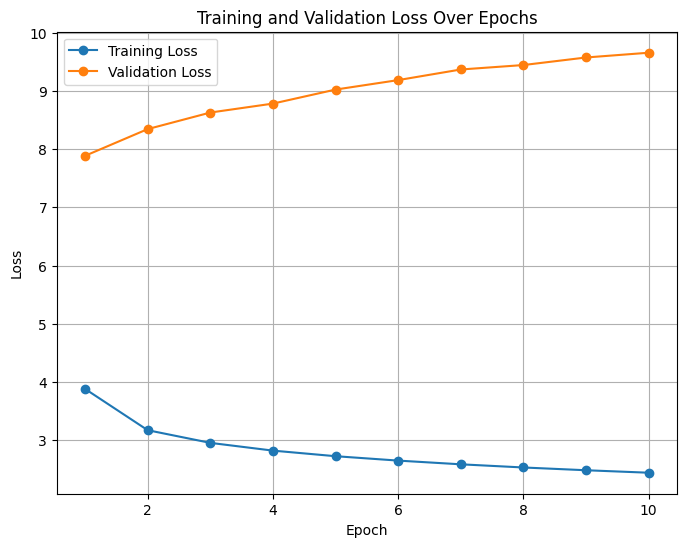

In [21]:
plt.figure(figsize=(8, 6))

# Plot Training and Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')

# Set labels and title
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

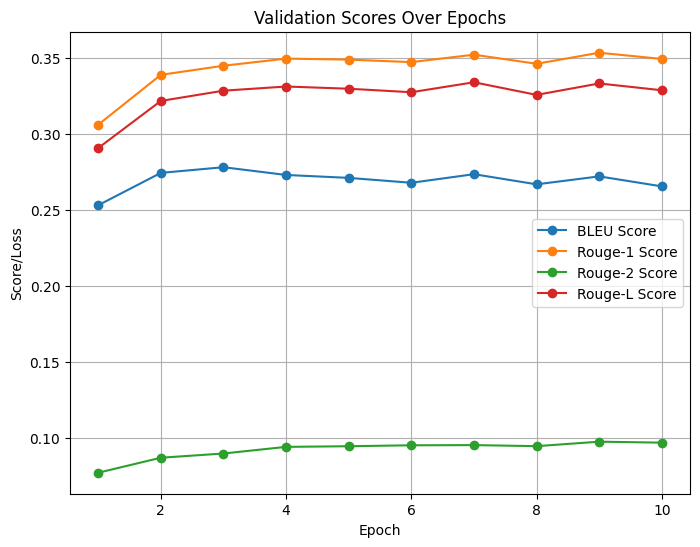

In [22]:

# Plot all scores in one plot
plt.figure(figsize=(8, 6))

# Plot BLEU Score
plt.plot(range(1, num_epochs+1), bleu_scores, label='BLEU Score', marker='o')

# Plot Rouge-1 Score
plt.plot(range(1, num_epochs+1), rouge_1s, label='Rouge-1 Score', marker='o')

# Plot Rouge-2 Score
plt.plot(range(1, num_epochs+1), rouge_2s, label='Rouge-2 Score', marker='o')

# Plot Rouge-L Score
plt.plot(range(1, num_epochs+1), rouge_ls, label='Rouge-L Score', marker='o')

# Set labels and title
plt.title('Validation Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score/Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

  a dog is running through water . <EOS>


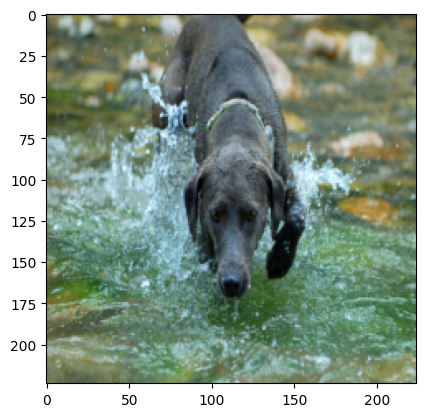

In [31]:
model.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    img,_ = next(dataiter)
    features = model.encoder(img[0:1].to(device))
    caps,alphas = model.decoder.generate_caption(features,vocab=trainset.vocab)
    caption = ' '.join(caps)
    print(caption)
    show_image(img[0])

model.train();